In [1]:
import pandas as pd 
import numpy as np
from astropy.table import Table
import matplotlib.pyplot as plt
from matplotlib import rc
rc('font', **{'size':18})
%matplotlib inline
from multiprocessing import Pool
# from profilestats import profile
from scipy.stats import binned_statistic
from funcs.analysis.analysis import *
from os import listdir
import os
import time
from funcs.preprocessing.binning import bin_data
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
wdir = '/disk1/hrb/python/'
band = 'r'

# t_max w/o SSA = 6751 for qsos
# t_max w/o SSA = 7772 for stars
# config = {'obj':'qsos'       ,'ID':'uid'  ,'t_max':23576,'n_bins_t':200,'n_bins_m':200,'n_t_chunk':19, 'width':2, 'steepness':0.005}
config = {'obj':'calibStars','ID':'uid_s','t_max':25600,'n_bins_t':200,'n_bins_m':200,'n_t_chunk':19, 'width':1, 'steepness':0.005}

width   = config['width']
steepness = config['steepness']
obj = config['obj']
ID  = config['ID']
t_max = config['t_max']
n_bins_t = config['n_bins_t']
n_bins_m = config['n_bins_m']
n_t_chunk = config['n_t_chunk']

data_path = wdir+'data/computed/{}/dtdm/raw/{}/'.format(obj,band)

# sort based on filesize, then do ordered shuffle so that each core recieves the same number of large files
fnames = [a for a in listdir(data_path) if (len(a)>27)]
size=[]
for file in fnames:
    size.append(os.path.getsize(data_path+file))
    

fnames = [name for i in [0,1,2,3] for sizename, name in sorted(zip(size, fnames))[i::4]]

In [3]:
import pandas as pd 
pd.options.mode.chained_assignment = None
import numpy as np
from astropy.table import Table
import matplotlib.pyplot as plt
import matplotlib
from multiprocessing import Pool
# from profilestats import profile
from scipy.stats import binned_statistic
from funcs.analysis.analysis import *
%matplotlib inline

def reader(n_subarray):
    return pd.read_csv('../data/merged/{}/r_band/lc_{}.csv'.format(obj,n_subarray), comment='#', nrows=None, index_col = ID, dtype = {'catalogue': np.uint8, 'mag_ps': np.float32, 'magerr': np.float32, 'mjd': np.float64, ID: np.uint32})

In [4]:
obj = 'calibStars'
ID  = 'uid_s'
band = 'r'
redshift_bool = False
dr = analysis(ID, obj)

In [5]:
# dr.read_in(reader, redshift=redshift_bool)
dr.band = band
dr.group(keys = ['uid_s'],read_in=True, redshift=redshift_bool)

In [6]:
fpath = data_path + fnames[5]
df = pd.read_csv(fpath, index_col = ID, dtype = {ID: np.uint32, 'dt': np.float32, 'dm': np.float32, 'de': np.float32, 'cat': np.uint8});

In [7]:
# # combining several dtdm files into one. Takes a little while to run.
# # We have already run and saved this
# df_list = []
# for fname in fnames:
#     df = pd.read_csv(fpath, index_col = ID, dtype = {ID: np.uint32, 'dt': np.float32, 'dm': np.float32, 'de': np.float32, 'cat': np.uint8});
#     df = df[df['cat']==2]
#     df_list.append(df)
# df = pd.concat(df_list)

In [19]:
# load in dtdm ps ssa pairwise observations
df = pd.read_csv('transformations/ssa_error_calculation/dtdm_ps_ssa.csv', index_col='uid_s')
df = df.join(dr.df_grouped['mag_mean'], on='uid_s')

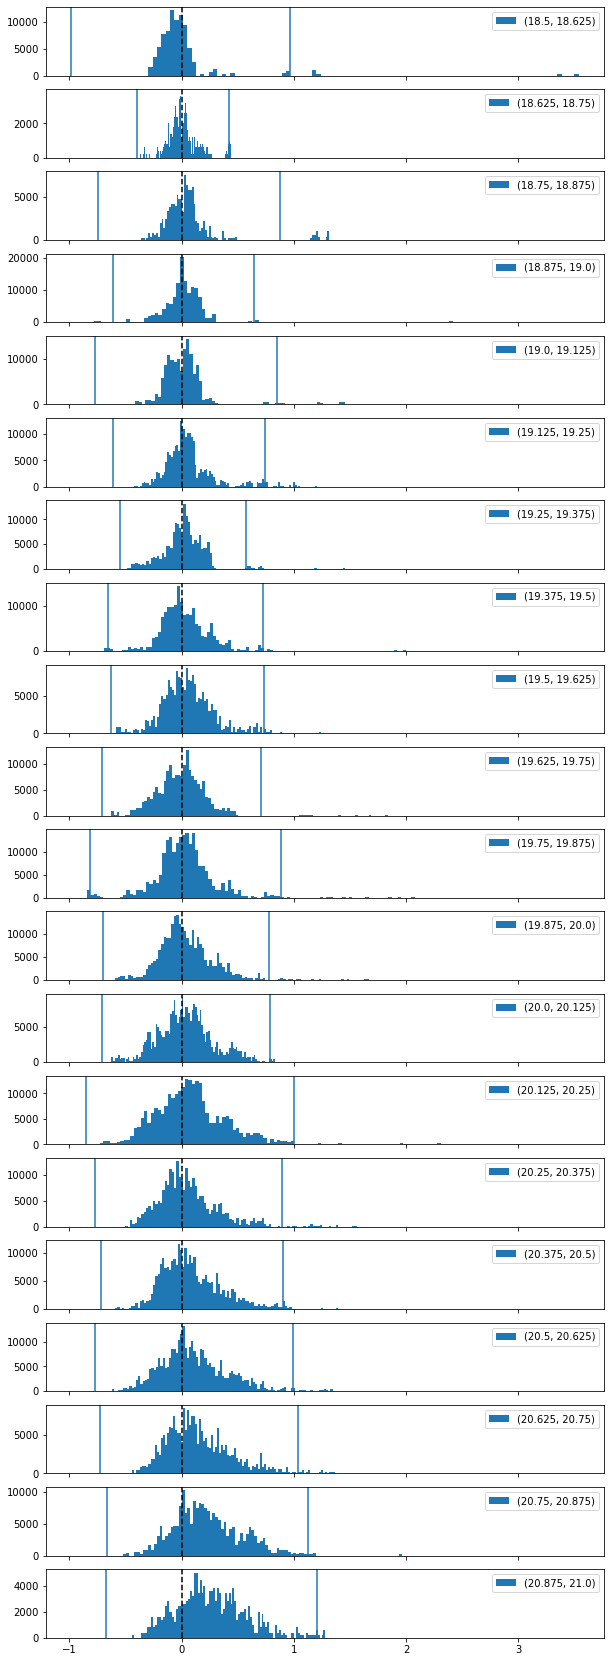

In [78]:
# plot the dm with with increasing mag slices
var = []
n=21
x = np.linspace(18.5, 21, n)
fig, ax = plt.subplots(n-1,1, figsize=(10,30), sharex=True)
intervals = [(x[i], x[i+1]) for i in range(len(x)-1)]
for i, interval in enumerate(intervals):
    lower, upper = interval
    subdf = df[(lower < df['mag_mean']) & (df['mag_mean'] < upper)]
    
    mean = subdf['dm'].mean()
    std  = subdf['dm'].std()
    
    z = (subdf['dm'] - mean)/std
    ax[i].axvline(x=mean + std*3)
    ax[i].axvline(x=mean - std*3)
    ax[i].axvline(x=0, color='k', ls='--')
    
    ax[i].hist(subdf['dm'], bins=100, label=str(interval))
    subdf = subdf[np.abs(z) < 3] 
    var.append(subdf['dm'].std())
    ax[i].legend()

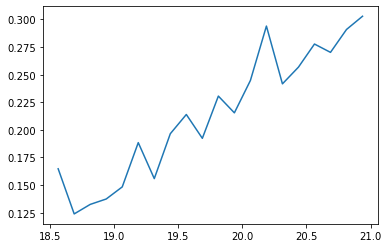

In [79]:
# plot the widths vs mag slices and save result
centres = (x[1:] + x[:-1])/2
plt.plot(centres, var)
np.savetxt('transformations/ssa_error_calculation/ps_ssa_mag_magerr.csv',np.array([centres,var]).T, delimiter = ',', fmt='%.5f')

In [80]:
# df = df.join(dr.df_grouped['mag_mean'], on='uid_s')

In [71]:
# df2=pd.read_csv('../data/surveys/ps/calibStars/gb.csv')
# df2 = df2[df2['filtercode'] == 'r']
# result = dr.df.groupby('uid_s').agg({'mag':'median','magerr':'median'})

In [81]:
# var = []
# n=21
# intervals = [(x[i], x[i+1]) for i in range(len(x)-1)]
# for i, interval in enumerate(intervals):
#     lower, upper = interval
#     subdf = df[(lower < df['mag']) & (df['mag'] < upper)]
#     var.append(subdf['magerr'].mean())

In [82]:
intervals = [(x[i], x[i+1]) for i in range(len(x)-1)]
centres = (x[1:] + x[:-1])/2

In [83]:
a = np.loadtxt('transformations/ssa_error_calculation/ps_mag_magerr.csv', delimiter=',')
b = np.loadtxt('transformations/ssa_error_calculation/ps_ssa_mag_magerr.csv', delimiter=',')

In [84]:
a

array([[1.8575e+01, 1.3980e-02],
       [1.8725e+01, 1.4730e-02],
       [1.8875e+01, 1.5620e-02],
       [1.9025e+01, 1.6890e-02],
       [1.9175e+01, 1.8420e-02],
       [1.9325e+01, 2.0320e-02],
       [1.9475e+01, 2.2540e-02],
       [1.9625e+01, 2.5430e-02],
       [1.9775e+01, 2.8230e-02],
       [1.9925e+01, 3.1610e-02],
       [2.0075e+01, 3.5640e-02],
       [2.0225e+01, 4.0230e-02],
       [2.0375e+01, 4.5290e-02],
       [2.0525e+01, 5.1250e-02],
       [2.0675e+01, 5.7560e-02],
       [2.0825e+01, 6.4580e-02],
       [2.0975e+01, 7.2660e-02],
       [2.1125e+01, 8.1870e-02],
       [2.1275e+01, 9.3320e-02],
       [2.1425e+01, 1.0568e-01]])

(0.06750823793971435, -1.1243623633720996)

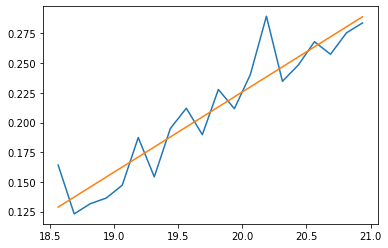

In [85]:
ssa_magerr = np.sqrt(b[:,1]**2 - a[:,1]**2)
m, c = np.polyfit(centres, ssa_magerr, 1)
plt.plot(centres, ssa_magerr)
plt.plot(centres, m*centres+c)
m,c

# maybe start from 15th mag?